In [1]:
from matplotlib.collections import PathCollection
import matplotlib.pyplot as plt
import h5py
import numpy as np 
from ripser import Rips, ripser
from sklearn import preprocessing
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.stats import binned_statistic_2d, pearsonr
from scipy.sparse import coo_matrix
from scipy.linalg import eigh
from scipy.sparse.linalg import lsmr
from scipy import stats
from datetime import datetime 
import time
import functools
from scipy import signal
from scipy import optimize
import sys
import numba

import matplotlib.pyplot as plt
import h5py
import numpy as np 
from ripser import Rips, ripser
from sklearn import preprocessing
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.stats import binned_statistic
from scipy.sparse import coo_matrix
from scipy.linalg import eigh
from scipy.sparse.linalg import lsmr
from scipy import stats
import scipy.io as sio
from scipy.interpolate import CubicSpline
from sklearn.cluster import AgglomerativeClustering
import umap
from datetime import datetime 
import time
import functools
from scipy import signal
from scipy import optimize
import sys
import numba
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec, transforms
from scipy.special import factorial
import pickle
import glob
import re
import os
#from utils_tda import *
gen_fn_dir = os.path.abspath('..') + '/shared_scripts'
sys.path.append(gen_fn_dir)

def get_coords(cocycle, threshold, num_sampled, dists, coeff):
    zint = np.where(coeff - cocycle[:, 2] < cocycle[:, 2])
    cocycle[zint, 2] = cocycle[zint, 2] - coeff
    d = np.zeros((num_sampled, num_sampled))
    d[np.tril_indices(num_sampled)] = np.NaN
    d[cocycle[:, 1], cocycle[:, 0]] = cocycle[:, 2]
    d[dists > threshold] = np.NaN
#    d[dists == 0] = np.NaN
    edges = np.where(~np.isnan(d))
    verts = np.array(np.unique(edges))
    num_edges = np.shape(edges)[1]
    num_verts = np.size(verts)

    values = d[edges]
    A = np.zeros((num_edges, num_verts), dtype=int)
    v1 = np.zeros((num_edges, 2), dtype=int)
    v2 = np.zeros((num_edges, 2), dtype=int)
    for i in range(num_edges):
        v1[i, :] = [i, np.where(verts == edges[0][i])[0]]
        v2[i, :] = [i, np.where(verts == edges[1][i])[0]]

    A[v1[:, 0], v1[:, 1]] = -1
    A[v2[:, 0], v2[:, 1]] = 1

    L = np.ones((num_edges,))
    Aw = A * np.sqrt(L[:, np.newaxis])
    Bw = values * np.sqrt(L)

    f = lsmr(Aw, Bw)[0]%1
    return f, verts


def plot_phase_distribution(masscenters_1, masscenters_2):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.axis('off')
    num_neurons = len(masscenters_1[:,0])
    for i in np.arange(num_neurons):
        ax.scatter(masscenters_1[i,0], masscenters_1[i,1], s = 10, c = 'r')
        if len(masscenters_2)>0:
            ax.scatter(masscenters_2[i,0], masscenters_2[i,1], s = 10, c ='k')
            line = masscenters_1[i,:] - masscenters_2[i,:]
            dline = line[1]/line[0]
            if line[0]< - np.pi and line[1] < -np.pi:
                line = (-2*np.pi + masscenters_2[i,:]) - masscenters_1[i,:]
                dline = line[1]/line[0]
                if (masscenters_1[i,1] + (- masscenters_1[i,0])*dline)>0:
                    ax.plot([masscenters_1[i,0], 0],
                            [masscenters_1[i,1], masscenters_1[i,1] + (- masscenters_1[i,0])*dline],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([2*np.pi,2*np.pi + -(masscenters_1[i,1] + (- masscenters_1[i,0])*dline)/dline], 
                            [masscenters_1[i,1] + (- masscenters_1[i,0])*dline, 0],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([2*np.pi + -(masscenters_1[i,1] + (- masscenters_1[i,0])*dline)/dline, 
                             masscenters_2[i,0]], 
                            [2*np.pi,masscenters_2[i,1]],
                            c = 'k', lw = 1, alpha = 0.5)
                else:
                    ax.plot([masscenters_1[i,0], masscenters_1[i,0] + (- masscenters_1[i,1])/dline],
                            [masscenters_1[i,1], 0],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([masscenters_1[i,0] + (- masscenters_1[i,1])/dline, 0],
                            [2*np.pi, 2*np.pi + -(masscenters_1[i,0] + (- masscenters_1[i,1])/dline)*dline], 
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([2*np.pi, 
                             masscenters_2[i,0]], 
                            [2*np.pi + -(masscenters_1[i,0] + (- masscenters_1[i,1])/dline)*dline,
                            masscenters_2[i,1]],
                            c = 'k', lw = 1, alpha = 0.5)
            elif line[0]> np.pi and line[1] >np.pi:
                line = (2*np.pi + masscenters_2[i,:]) - masscenters_1[i,:]
                dline = line[1]/line[0]
                if (masscenters_1[i,0] + (2*np.pi - masscenters_1[i,1])/dline)<2*np.pi:
                    ax.plot([masscenters_1[i,0], masscenters_1[i,0] + (2*np.pi - masscenters_1[i,1])/dline],

                           [masscenters_1[i,1],2*np.pi],
                           c = 'k', lw = 1, alpha = 0.5)
                    ax.plot([masscenters_1[i,0] + (2*np.pi - masscenters_1[i,1])/dline, 2*np.pi],
                           [0,(2*np.pi - (masscenters_1[i,0] + (2*np.pi - masscenters_1[i,1])/dline))*dline], 
                           c = 'k', lw = 1, alpha = 0.5)
                    ax.plot([0,masscenters_2[i,0]],
                           [(2*np.pi - (masscenters_1[i,0] + (2*np.pi - masscenters_1[i,1])/dline))*dline, 
                            masscenters_2[i,1]], 
                           c = 'k', lw = 1, alpha = 0.5)          
                else:
                    ax.plot([masscenters_1[i,0],2*np.pi],
                            [masscenters_1[i,1], masscenters_1[i,1] + (2*np.pi - masscenters_1[i,0])*dline],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([0,(2*np.pi - (masscenters_1[i,1] + (2*np.pi - masscenters_1[i,0])*dline))/dline], 
                            [masscenters_1[i,1] + (2*np.pi - masscenters_1[i,0])*dline, 2*np.pi],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([(2*np.pi - (masscenters_1[i,1] + (2*np.pi - masscenters_1[i,0])*dline))/dline, 
                             masscenters_2[i,0]], 
                            [0,masscenters_2[i,1]],
                            c = 'k', lw = 1, alpha = 0.5)#
            elif line[0]>np.pi and line[1] <-np.pi:  
                line = [2*np.pi + masscenters_2[i,0], -2*np.pi + masscenters_2[i,1]] - masscenters_1[i,:]
                dline = line[1]/line[0]            
                if (masscenters_1[i,1] + (2*np.pi - masscenters_1[i,0])*dline)>0:
                    ax.plot([masscenters_1[i,0],2*np.pi],
                            [masscenters_1[i,1], masscenters_1[i,1] + (2*np.pi - masscenters_1[i,0])*dline],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([0,(-(masscenters_1[i,1] + (2*np.pi - masscenters_1[i,0])*dline))/dline], 
                            [masscenters_1[i,1] + (2*np.pi - masscenters_1[i,0])*dline, 0],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([(-(masscenters_1[i,1] + (2*np.pi - masscenters_1[i,0])*dline))/dline, 
                             masscenters_2[i,0]], 
                            [2*np.pi,masscenters_2[i,1]],
                            c = 'k', lw = 1, alpha = 0.5)

                else:
                    line = [2*np.pi + masscenters_2[i,0], -2*np.pi + masscenters_2[i,1]] - masscenters_1[i,:]
                    dline = line[1]/line[0]
                    ax.plot([masscenters_1[i,0], masscenters_1[i,0] + (- masscenters_1[i,1])/dline],
                            [masscenters_1[i,1], 0],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([masscenters_1[i,0] + (- masscenters_1[i,1])/dline, 2*np.pi], 
                            [2*np.pi, 2*np.pi + (2*np.pi- masscenters_1[i,0] + (- masscenters_1[i,1])/dline)*dline],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([0, masscenters_2[i,0]], 
                            [2*np.pi + (2*np.pi- masscenters_1[i,0] + (- masscenters_1[i,1])/dline)*dline,masscenters_2[i,1]],
                            c = 'k', lw = 1, alpha = 0.5)
            elif line[0]<-np.pi and line[1] >np.pi:
                line = [-2*np.pi + masscenters_2[i,0], 2*np.pi + masscenters_2[i,1]] - masscenters_1[i,:]
                dline = line[1]/line[0]
                if ((masscenters_1[i,1] + -(masscenters_1[i,0])*dline)<2*np.pi):

                    ax.plot([masscenters_1[i,0],0],
                            [masscenters_1[i,1], masscenters_1[i,1] + -(masscenters_1[i,0])*dline],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([2*np.pi, 2*np.pi + (2*np.pi - (masscenters_1[i,1] + -(masscenters_1[i,0])*dline))/dline], 
                            [masscenters_1[i,1] + -(masscenters_1[i,0])*dline, 2*np.pi],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([2*np.pi + (2*np.pi - (masscenters_1[i,1] + -(masscenters_1[i,0])*dline))/dline, 
                             masscenters_2[i,0]], 
                            [0,masscenters_2[i,1]],
                            c = 'k', lw = 1, alpha = 0.5)
                else:
                    ax.plot([masscenters_1[i,0], masscenters_1[i,0] + (2*np.pi-masscenters_1[i,1])/dline],
                            [masscenters_1[i,1], 2*np.pi],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([masscenters_1[i,0] + (2*np.pi-masscenters_1[i,1])/dline, 0], 
                            [0, 0 + -(masscenters_1[i,0] + (2*np.pi-masscenters_1[i,1])/dline)*dline],
                            c = 'k', lw = 1, alpha = 0.5)

                    ax.plot([2*np.pi, masscenters_2[i,0]], 
                            [0 + -(masscenters_1[i,0] + (2*np.pi-masscenters_1[i,1])/dline)*dline,masscenters_2[i,1]],
                            c = 'k', lw = 1, alpha = 0.5)

            elif line[0]< -np.pi:
                line = [(2*np.pi + masscenters_1[i,0]), masscenters_1[i,1]] - masscenters_2[i,:]
                dline = line[1]/line[0]
                ax.plot([masscenters_2[i,0],2*np.pi],
                        [masscenters_2[i,1], masscenters_2[i,1] + (2*np.pi - masscenters_2[i,0])*dline], 
                        alpha = 0.5, c = 'k', lw = 1)            
                ax.plot([0,masscenters_1[i,0]],
                        [masscenters_2[i,1] + (2*np.pi - masscenters_2[i,0])*dline, masscenters_1[i,1]], 
                        alpha = 0.5, c = 'k', lw = 1)
            elif line[0]> np.pi:
                line = [ masscenters_2[i,0]+ 2*np.pi, masscenters_2[i,1]] - masscenters_1[i,:]
                dline = line[1]/line[0]


                ax.plot([masscenters_1[i,0],2*np.pi],
                        [masscenters_1[i,1], masscenters_1[i,1] + (2*np.pi - masscenters_1[i,0])*dline],
                        c = 'k', lw = 1, alpha = 0.5)
                ax.plot([0,masscenters_2[i,0]],
                        [masscenters_1[i,1] + (2*np.pi - masscenters_1[i,0])*dline, masscenters_2[i,1]], 
                        alpha = 0.5, c = 'k', lw = 1)
            elif line[1]< -np.pi:
                line = [ masscenters_1[i,0], (2*np.pi + masscenters_1[i,1])] - masscenters_2[i,:]
                dline = line[1]/line[0]

                ax.plot([masscenters_2[i,0], masscenters_2[i,0] + (2*np.pi - masscenters_2[i,1])/dline], 
                        [masscenters_2[i,1],2*np.pi], alpha = 0.5, c = 'k', lw = 1),
                ax.plot([masscenters_1[i,0] - masscenters_1[i,1]/dline,masscenters_1[i,0]],
                        [0, masscenters_1[i,1]], 
                        alpha = 0.5, c = 'k', lw = 1)
            elif line[1]> np.pi:
                line = [ masscenters_2[i,0], masscenters_2[i,1]+ 2*np.pi] - masscenters_1[i,:]
                dline = line[1]/line[0]

                ax.plot([masscenters_1[i,0], masscenters_1[i,0] + (2*np.pi - masscenters_1[i,1])/dline], 
                        [masscenters_1[i,1], 2*np.pi], alpha = 0.5, c = 'k', lw = 1),

                ax.plot([masscenters_1[i,0] + (2*np.pi - masscenters_1[i,1])/dline,masscenters_2[i,0]],
                        [0, masscenters_2[i,1]], 
                        alpha = 0.5, c = 'k', lw = 1)
            else:
                ax.plot([masscenters_1[i,0],masscenters_2[i,0]],
                        [masscenters_1[i,1],masscenters_2[i,1]], 
                        alpha = 0.5, c = 'k', lw = 1)

    ax.plot([0,0], [0,2*np.pi], c = 'k')
    ax.plot([0,2*np.pi], [0,0], c = 'k')
    ax.plot([2*np.pi,2*np.pi], [0,2*np.pi], c = 'k')
    ax.plot([0,2*np.pi], [2*np.pi,2*np.pi], c = 'k')

    r_box = transforms.Affine2D().skew_deg(15,15)
    for x in ax.images + ax.lines + ax.collections + ax.get_xticklabels() + ax.get_yticklabels():
        trans = x.get_transform()
        x.set_transform(r_box+trans) 
        if isinstance(x, PathCollection):
            transoff = x.get_offset_transform()
            x._transOffset = r_box+transoff 
    ax.set_xlim([0,2*np.pi + 3/5*np.pi])
    ax.set_ylim([0,2*np.pi + 3/5*np.pi])
    ax.set_aspect('equal', 'box')
    return ax



def get_coords_ds(rips_real, len_indstemp, ph_classes = [0,1], dec_thresh = 0.99, coeff = 47):
    num_circ = len(ph_classes)    
    ################### Decode coordinates ####################
    diagrams = rips_real["dgms"] # the multiset describing the lives of the persistence classes
    cocycles = rips_real["cocycles"][1] # the cocycle representatives for the 1-dim classes
    dists_land = rips_real["dperm2all"] # the pairwise distance between the points 
    births1 = diagrams[1][:, 0] #the time of birth for the 1-dim classes
    deaths1 = diagrams[1][:, 1] #the time of death for the 1-dim classes
    deaths1[np.isinf(deaths1)] = 0
    lives1 = deaths1-births1 # the lifetime for the 1-dim classes
    iMax = np.argsort(lives1)
    coords1 = np.zeros((num_circ, len_indstemp))
    for j,c in enumerate(ph_classes):
        cocycle = cocycles[iMax[-(c+1)]]
        threshold = births1[iMax[-(c+1)]] + (deaths1[iMax[-(c+1)]] - births1[iMax[-(c+1)]])*dec_thresh
        coordstemp,inds = get_coords(cocycle, threshold, len_indstemp, dists_land, coeff)
        coords1[j,inds] = coordstemp
    return coords1

def get_coords_all(sspikes2, coords1, times_cube, indstemp, dim = 7, spk2 = [], bPred = False, bPCA = False):
    num_circ = len(coords1)
    spkmean = np.mean(sspikes2[times_cube,:], axis = 0)
    spkstd = np.std(sspikes2[times_cube,:], axis = 0)
    spkscale = (sspikes2-spkmean)/spkstd
    dspk1 = spkscale.copy()
    if bPCA:
        __, e1, e2,__ = pca(spkscale[times_cube,:], dim = dim)
        dspk1 = np.dot(e1.T, spkscale.T).T    
        dspk1 /= np.sqrt(e2)    
        
    dspk = dspk1[indstemp,:]
    if len(spk2)>0:
        dspk1 = (spk2-spkmean)/spkstd
        if bPCA:
            dspk1 = np.dot(e1.T, dspk1.T).T    
            dspk1 /= np.sqrt(e2)    


    if bPred:
        coords_mod1 = np.zeros((len(dspk1), num_circ))
        coords_mod1[:,0] = predict_color(coords1[0,:], dspk1, dspk, 
                                     dist_measure='cosine',  k = 30)
        coords_mod1[:,1] = predict_color(coords1[1,:],  dspk1, dspk,
                                         dist_measure='cosine',  k = 30)
    else:
        num_neurons = len(dspk[0,:])
        centcosall = np.zeros((num_neurons, num_circ, len(indstemp)))
        centsinall = np.zeros((num_neurons, num_circ, len(indstemp)))    
        for neurid in range(num_neurons):
            spktemp = dspk[:, neurid].copy()
            centcosall[neurid,:,:] = np.multiply(np.cos(coords1[:, :]*2*np.pi),spktemp)
            centsinall[neurid,:,:] = np.multiply(np.sin(coords1[:, :]*2*np.pi),spktemp)

        a = np.zeros((len(dspk1), num_circ, num_neurons))
        for n in range(num_neurons):
            a[:,:,n] = np.multiply(dspk1[:,n:n+1],np.sum(centcosall[n,:,:],1))

        c = np.zeros((len(dspk1), num_circ, num_neurons))
        for n in range(num_neurons):
            c[:,:,n] = np.multiply(dspk1[:,n:n+1],np.sum(centsinall[n,:,:],1))

        mtot2 = np.sum(c,2)
        mtot1 = np.sum(a,2)
        coords_mod1 = np.arctan2(mtot2,mtot1)%(2*np.pi)
    return coords_mod1

def get_cross(sspikes, mouse_sess, lencorr = 10, data_dir = 'place_data', bload = False):
    if bload:
        crosscorrfile = glob.glob(data_dir + '/' + mouse_sess + '_crosscorrs.npz')
        f = np.load(crosscorrfile[0], allow_pickle = True)
        crosscorrs = f['crosscorrs'][()]
        f.close()
    else:
        lenspk, num_neurons = np.shape(sspikes)
        crosscorrs = np.zeros((len(sspikes[0,:]), len(sspikes[0,:]), lencorr*2+1))
        spksum = np.sum(sspikes,0)
        spksum_all = np.zeros((num_neurons, num_neurons))
        for i in range(num_neurons):
            for j in range(num_neurons):
                spksum_all[i,j] = spksum[j]*spksum[i]
        times_all = {}
        
        for it, t1 in enumerate(np.arange(-lencorr, lencorr+1)):
            times_all[it] = np.arange(0,lenspk)+t1+lencorr
            
        for i in range(num_neurons):
            spktemp = np.concatenate((np.zeros(lencorr), sspikes[:,i], np.zeros(lencorr)))
            for j in range(i+1, num_neurons):
                for it in times_all:
                    crosscorrs[i,j,it] = np.dot(sspikes[:,j],spktemp[times_all[it]])/spksum_all[i,j]       
#                print(crosscorrs[i,j,:])
        np.savez(data_dir + '/' + mouse_sess + '_crosscorrs', crosscorrs = crosscorrs)
    return crosscorrs


def get_crossmat(crosscorr_train, lenspk, lencorr = -1):
    num_neurons = len(crosscorr_train)
    crosscorrs = np.zeros((num_neurons,num_neurons))
    num_neurons = len(crosscorr_train[:,0,0])
    lenorig = int(len(crosscorr_train[0,0,:])/2)
    if lencorr==-1:
        lencorr = lenorig
    for i in range(num_neurons):
        for j in range(i+1, num_neurons):
            c = crosscorr_train[i,j,lenorig-lencorr:lenorig+lencorr+1].copy()*lenspk
#            print(c)

#            c = crosscorr_train[i,j,:].copy()*lenspk
            if np.min(c)>0:
                crosscorrs[i,j] +=  1-np.exp(-np.square(np.min(c)/np.max(c)))
                #crosscorrs[i,j] +=  1/(np.max(c)-np.min(c))#np.mean(np.exp(-np.square(c)))#-np.min(c))#np.exp(-np.sum(c))#-np.min(c)
            crosscorrs[j,i] = crosscorrs[i,j]
    print(np.unique(crosscorrs))
    crosscorrs[np.isnan(crosscorrs)] = 1
    crosscorrs[np.isinf(crosscorrs)] = 1
    return crosscorrs


def get_dgms(sspikes2, maxdim = 1, omega = 1, k  = 1000, 
    n_points = 800, dim = 7, nbs = 800, eps = 1, metric = 'cosine', 
             indstemp = [],movetimes1 = []):    
    dgms_all = {}
    dim_red_spikes_move_scaled = preprocessing.scale(sspikes2, axis = 0)
        
    if dim > 0:
        dim_red_spikes_move_scaled, e1, e2, var_exp = pca(dim_red_spikes_move_scaled, dim = dim)
        dim_red_spikes_move_scaled /= np.sqrt(e2[:dim])  
    else:
        var_exp = 0
    if len(indstemp)==0:
        if len(movetimes1) == 0:
            startindex = np.argmax(np.sum(np.abs(dim_red_spikes_move_scaled),1))
            if eps > 0:
                movetimes1 = radial_downsampling(dim_red_spikes_move_scaled, metric = 'euclidean', epsilon = eps, 
                    startindex = startindex)
            else:
                movetimes1 = np.arange(len(dim_red_spikes_move_scaled))
        if n_points> len(movetimes1):
            indstemp = movetimes1.copy()
        else:
        
            indstemp,__  = sample_denoising(dim_red_spikes_move_scaled[movetimes1,:],  k, 
                                               n_points, omega, metric)
            indstemp = movetimes1[indstemp]
    dim_red_spikes_move_scaled = dim_red_spikes_move_scaled[indstemp,:]
    X = squareform(pdist(dim_red_spikes_move_scaled[:,:], metric))
    knn_indices = np.argsort(X)[:, :nbs]
    knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()
    sigmas, rhos = smooth_knn_dist(knn_dists, nbs, local_connectivity=0)
    rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
    result = coo_matrix((vals, (rows, cols)), shape=(X.shape[0], X.shape[0]))
    result.eliminate_zeros()
    transpose = result.transpose()
    prod_matrix = result.multiply(transpose)
    result = (result + transpose - prod_matrix)
    result.eliminate_zeros()
    d = result.toarray()
    d = -np.log(d)
    np.fill_diagonal(d,0)
    thresh = np.max(d[~np.isinf(d)])
    if maxdim == 2:
        hom_dims = list(range(maxdim+1))
        VR = VietorisRipsPersistence(
        homology_dimensions=hom_dims,
        metric='precomputed',
        coeff=47,
        max_edge_length= thresh,
        collapse_edges=False,  # True faster?
        n_jobs=None  # -1 faster?
        )
        diagrams = VR.fit_transform([d])
        dgms_all[0] = from_giotto_to_ripser(diagrams[0])
        persistence = []
    else:
        persistence = ripser(d, maxdim=1, coeff=47, do_cocycles= True, distance_matrix = True, thresh = thresh)    
        dgms_all[0] = persistence['dgms'] 
    return dgms_all, persistence, indstemp, movetimes1, var_exp

def plot_barcode(persistence, file_name = '', shuffle_name = ''):
    if np.sum(np.isinf(persistence[0])) == 0:
        persistence[0] = np.concatenate((persistence[0], np.array([0,np.inf])[np.newaxis, :]))
    diagrams_roll = {}
    if len(shuffle_name)>0:
        f = np.load(shuffle_name + '.npz', allow_pickle = True)
        diagrams_roll = f['dgms_shuffles'][()]
        f.close() 

    alpha=1
    inf_delta=0.1
    legend=True
    maxdim = len(persistence)-1
    cs = np.repeat([[0,0.55,0.2]],maxdim+1).reshape(3, maxdim+1).T
    colormap=cs
    dims =np.arange(maxdim+1)
    num_rolls = len(diagrams_roll)
    print(num_rolls)
    if num_rolls>0:
        diagrams_all = np.copy(diagrams_roll[0][0])
        for i in np.arange(1, num_rolls):
            for d in dims:
                diagrams_all[d] = np.concatenate((diagrams_all[d], diagrams_roll[i][0][d]),0)
        infs = np.isinf(diagrams_all[0])
        diagrams_all[0][infs] = 0
        diagrams_all[0][infs] = np.max(diagrams_all[0])
        infs = np.isinf(diagrams_all[0])
        diagrams_all[0][infs] = 0
        diagrams_all[0][infs] = np.max(diagrams_all[0])


    min_birth, max_death = 0,0            
    for dim in dims:
        persistence_dim = persistence[dim][~np.isinf(persistence[dim][:,1]),:]
        if len(persistence_dim)>0:
            min_birth = min(min_birth, np.min(persistence_dim))
            max_death = max(max_death, np.max(persistence_dim))
    delta = (max_death - min_birth) * inf_delta
    infinity = max_death + delta
    axis_start = min_birth - delta            
    plotind = (dims[-1]+1)*100 + 10 +1
    fig = plt.figure(figsize = (3,5), dpi = 160)
    gs = gridspec.GridSpec(len(dims),1, height_ratios = [min(len(persistence[dim]),30) for dim in dims])
    indsall =  0
    labels = ["$H_0$", "$H_1$", "$H_2$"]
    for dit, dim in enumerate(dims):
        axes = plt.subplot(gs[dim])
        axes.axis('off')
        d = np.copy(persistence[dim])
        d[np.isinf(d[:,1]),1] = infinity
        dlife = (d[:,1] - d[:,0])
        if len(dlife)>1:
            dinds = np.argsort(dlife)[-30:]
            dl1,dl2 = dlife[dinds[-2:]]
        else:
            dinds = np.array([0])
        if dim>0:
            dinds = dinds[np.flip(np.argsort(d[dinds,0]))]
        axes.barh(
            0.5+np.arange(len(dinds)),
            dlife[dinds],
            height=0.8,
            left=d[dinds,0],
            alpha=alpha,
            color=colormap[dim],
            linewidth=0,
        )
        indsall = len(dinds)
        if num_rolls>0:
            bins = 50
            cs = np.flip([[0.4,0.4,0.4], [0.6,0.6,0.6], [0.8, 0.8,0.8]])
            cs = np.repeat([[1,0.55,0.1]],3).reshape(3,3).T
            cc = 0
            lives1_all = diagrams_all[dim][:,1] - diagrams_all[dim][:,0]
            x1 = np.linspace(diagrams_all[dim][:,0].min()-1e-5, diagrams_all[dim][:,0].max()+1e-5, bins-2)
            
            dx1 = (x1[1] - x1[0])
            x1 = np.concatenate(([x1[0]-dx1], x1, [x1[-1]+dx1]))
            dx = x1[:-1] + dx1/2
            ytemp = np.zeros((bins-1))
            binned_birth = np.digitize(diagrams_all[dim][:,0], x1)-1
            x1  = d[dinds,0]
            ytemp =x1 + np.max(lives1_all)
            axes.fill_betweenx(0.5+np.arange(len(dinds)), x1, ytemp, color = cs[(dim)], zorder = -2, alpha = 0.3)

        axes.plot([0,0], [-0.5, indsall], c = 'k', linestyle = '-', lw = 3)
        axes.plot([0,infinity],[-0.5,-0.5], c = 'k', linestyle = '-', lw = 3)
        axes.set_xlim([0, infinity])
        print('infinity', infinity)
    
    plt.tight_layout()
    return fig



def pca(data, dim=2):
    if dim < 1:
        return data, [0]
    m, n = data.shape
    # mean center the data
    # data -= data.mean(axis=0)
    # calculate the covariance matrix
    R = np.cov(data, rowvar=False)
    # calculate eigenvectors & eigenvalues of the covariance matrix
    # use 'eigh' rather than 'eig' since R is symmetric,
    # the performance gain is substantial
    evals, evecs = np.linalg.eig(R)
    # sort eigenvalue in decreasing order
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    # sort eigenvectors according to same index
    evals = evals[idx]
    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    evecs = evecs[:, :dim]
    # carry out the transformation on the data using eigenvectors
    # and return the re-scaled data, eigenvalues, and eigenvectors

    tot = np.sum(evals)
    var_exp = [(i / tot) * 100 for i in sorted(evals[:], reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    components = np.dot(evecs.T, data.T).T
    return components, evecs, evals[:dim], var_exp
@numba.njit(parallel=True, fastmath=True)
def compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos):
    n_samples = knn_indices.shape[0]
    n_neighbors = knn_indices.shape[1]
    rows = np.zeros((n_samples * n_neighbors), dtype=np.int64)
    cols = np.zeros((n_samples * n_neighbors), dtype=np.int64)
    vals = np.zeros((n_samples * n_neighbors), dtype=np.float64)
    for i in range(n_samples):
        for j in range(n_neighbors):
            if knn_indices[i, j] == -1:
                continue  # We didn't get the full knn for i
            if knn_indices[i, j] == i:
                val = 0.0
            elif knn_dists[i, j] - rhos[i] <= 0.0:
                val = 1.0
            else:
                val = np.exp(-((knn_dists[i, j] - rhos[i]) / (sigmas[i])))
                #val = ((knn_dists[i, j] - rhos[i]) / (sigmas[i]))

            rows[i * n_neighbors + j] = i
            cols[i * n_neighbors + j] = knn_indices[i, j]
            vals[i * n_neighbors + j] = val

    return rows, cols, vals
@numba.njit(
    fastmath=True
)  # benchmarking `parallel=True` shows it to *decrease* performance
def smooth_knn_dist(distances, k, n_iter=64, local_connectivity=0.0, bandwidth=1.0):
    target = np.log2(k) * bandwidth
#    target = np.log(k) * bandwidth
#    target = k
    
    rho = np.zeros(distances.shape[0])
    result = np.zeros(distances.shape[0])

    mean_distances = np.mean(distances)

    for i in range(distances.shape[0]):
        lo = 0.0
        hi = np.inf
        mid = 1.0

        # TODO: This is very inefficient, but will do for now. FIXME
        ith_distances = distances[i]
        non_zero_dists = ith_distances[ith_distances > 0.0]
        if non_zero_dists.shape[0] >= local_connectivity:
            index = int(np.floor(local_connectivity))
            interpolation = local_connectivity - index
            if index > 0:
                rho[i] = non_zero_dists[index - 1]
                if interpolation > 1e-5:
                    rho[i] += interpolation * (
                        non_zero_dists[index] - non_zero_dists[index - 1]
                    )
            else:
                rho[i] = interpolation * non_zero_dists[0]
        elif non_zero_dists.shape[0] > 0:
            rho[i] = np.max(non_zero_dists)

        for n in range(n_iter):

            psum = 0.0
            for j in range(1, distances.shape[1]):
                d = distances[i, j] - rho[i]
                if d > 0:
                    psum += np.exp(-(d / mid))
#                    psum += d / mid
 
                else:
                    psum += 1.0
#                    psum += 0

            if np.fabs(psum - target) < 1e-5:
                break

            if psum > target:
                hi = mid
                mid = (lo + hi) / 2.0
            else:
                lo = mid
                if hi == np.inf:
                    mid *= 2
                else:
                    mid = (lo + hi) / 2.0
        result[i] = mid
        # TODO: This is very inefficient, but will do for now. FIXME
        if rho[i] > 0.0:
            mean_ith_distances = np.mean(ith_distances)
            if result[i] < 1e-3 * mean_ith_distances:
                result[i] = 1e-3 * mean_ith_distances
        else:
            if result[i] < 1e-3 * mean_distances:
                result[i] = 1e-3 * mean_distances

    return result, rho
def sample_denoising(data,  k = 10, num_sample = 500, omega = 1, metric = 'euclidean'):    
    n = data.shape[0]
    leftinds = np.arange(n)
    F_D = np.zeros(n)

    X = squareform(pdist(data, metric))
    knn_indices = np.argsort(X)[:, :k]
    knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()

    sigmas, rhos = smooth_knn_dist(knn_dists, k, local_connectivity=0)
    rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
    result = coo_matrix((vals, (rows, cols)), shape=(n, n))
    result.eliminate_zeros()
    transpose = result.transpose()
    prod_matrix = result.multiply(transpose)

    result = (result + transpose - prod_matrix)
    result.eliminate_zeros()
    X = result.toarray()
    F = np.sum(X,1)
    print(np.mean(F),np.median(F))
    Fs = np.zeros(num_sample)
    Fs[0] = np.max(F)
    i = np.argmax(F)
    inds_all = np.arange(n)
    inds_left = inds_all>-1
    inds_left[i] = False
    inds = []
    j = 0
    for j in np.arange(1,num_sample):
        F -= omega*X[i,:]
        Fmax = np.argmax(F[inds_left])
        Fs[j] = F[inds_left][Fmax]
        i = inds_all[inds_left][Fmax]
        
        inds_left[i] = False   
        inds.extend([i])
    return inds, Fs

def load_data(session):
    ff = glob.glob('Data/' + session + '_25.npz')
    if len(ff)>0:
        f = np.load(ff[0], allow_pickle = True)
        ccg = f['ccg'] 
        spikes_bin = f['spikes_bin'][()]
        hdd = f['hdd']
        xx = f['xx']
        yy = f['yy']    
        ind = f['ind']
        f.close()
    else:
        data_path = 'Data/' + session + '/'
        f = np.load(data_path + 'data.npz', allow_pickle = True)
        data = f['data'][()]
        f.close()        
        angle_list_orig = np.array(read_numerical_file('Data/' + session + '/' + session + '.ang', 'float', 'multiple'))
        angle_list = np.array(angle_list_orig[:,1])
        angle_list[angle_list < -0.5] = np.nan
        angle_times  =angle_list_orig[:,0]
        data['angle_list'] = angle_list
        data['angle_times'] = angle_times
        spike_times =data['spike_times']
        hd = data['angle_list']
        samp_rate = data['pos_sampling_rate']

        area_info = load_pickle_file('Data/area_shank_info.p')
        relevant_shanks = area_info[session]['ADn']
        spike_times1 = {}
        spikes_bin = {}
        
        it = 0
        for spk in spike_times:
            numspk = sum((spike_times[spk]>=data['state_times']['Wake'][0][0]) & 
                   (spike_times[spk]<=data['state_times']['Wake'][0][1]))
            lensess = data['state_times']['Wake'][0][1]-data['state_times']['Wake'][0][0]
            fr = numspk/lensess
    #        if spk[0] in relevant_shanks:
            if (fr>=0.05) | (fr<10):
                spike_times1[it] = spike_times[spk]
                it += 1
            else:
                print('fr ', fr)
            
        for brain_state in ['Wake', 'REM', 'SWS']:
            t_curr =  data['state_times'][brain_state]
            res = 100000
            if brain_state == 'SWS':
                dt = 200000
                sigma = 5000
            else:
                dt = 25000
                sigma = 25000
            thresh = 250000
            num_thresh = int(thresh/dt)
            num2_thresh = int(2*num_thresh)
            sig2 = 1/(2*(sigma/res)**2)
            ker = np.exp(-np.power(np.arange(thresh+1)/res, 2)*sig2)
            kerwhere = np.arange(-num_thresh,num_thresh)*dt

            spikes_bin_tmp = np.zeros((1,len(spike_times1)))
            for ttmp in t_curr:
                min_time = ttmp[0]*res
                max_time = ttmp[-1]*res
                tt = np.arange(np.floor(min_time), np.ceil(max_time)+1, dt)

                spikes_temp = np.zeros((len(tt)+num2_thresh, len(spike_times1)))
                for n, spk in enumerate(spike_times1):
                    spk = spike_times1[spk]
                    spikes = np.array(spk*res-min_time, dtype = int)
                    spikes = spikes[(spikes < (max_time-min_time)) & (spikes > 0)]
                    spikes_mod = dt-spikes%dt
                    spikes = np.array(spikes/dt, int)
                    for m, j in enumerate(spikes):
                        spikes_temp[j:j+num2_thresh, n] += ker[np.abs(kerwhere+spikes_mod[m])]
                spikes_temp = spikes_temp[num_thresh-1:-(num_thresh+1),:]
                spikes_bin_tmp = np.concatenate((spikes_bin_tmp, spikes_temp),0)
            spikes_bin[brain_state] = spikes_bin_tmp[1:,:]
            spikes_bin[brain_state] *= 1/np.sqrt(2*np.pi*(sigma/res)**2)
            if brain_state == 'Wake':
                pos_list_orig = np.array(read_numerical_file('Data/'+ session + '/' + session + '.pos', 'float', 'multiple'))
                t = pos_list_orig[:,0]
                x = pos_list_orig[:,1]
                y = pos_list_orig[:,2]
                tt/=res
                nnans = ~np.isnan(x)
                xspline = CubicSpline(t[nnans], x[nnans]) 
                nnans = ~np.isnan(y)
                yspline = CubicSpline(t[nnans], y[nnans]) 
                nnans = ~np.isnan(hd)
                hdsplinecos = CubicSpline(t[nnans], np.cos(hd[nnans]))
                hdsplinesin = CubicSpline(t[nnans], np.sin(hd[nnans]))
                xx = xspline(tt)
                yy = yspline(tt)
                hdd = np.arctan2(hdsplinesin(tt), hdsplinecos(tt))%(2*np.pi)   

        ccg = get_cross(session, data, spike_times1, data_dir = 'Data', spike_times = [], files = ['Wake', 'REM', 'SWS'])
        ind = get_ind(session, ccg, data_dir = 'Data', files = ['Wake', 'REM', 'SWS'], nbs = 0.6)

        np.savez('Data/' + session + '_25', ind = ind, ccg = ccg, spikes_bin = spikes_bin, hdd = hdd, xx = xx, yy = yy)
    return ind, ccg, spikes_bin, hdd, xx, yy

def get_ind(crosscorrs, nbs = -1, linkage = 'average'):
    ################### Get crosscorr stats ####################
    crosscorrs[np.isinf(crosscorrs)] = 2*np.max(crosscorrs[~np.isinf(crosscorrs)])
    agg = AgglomerativeClustering(n_clusters=None,affinity='precomputed', linkage=linkage, 
                                  distance_threshold=nbs)
    ind = agg.fit(crosscorrs).labels_
    
    fig = plt.figure()
    crosscorrs = crosscorrs[np.argsort(ind), :]
    crosscorrs = crosscorrs[:, np.argsort(ind)]    
    plt.imshow(crosscorrs)
    return ind

def radial_downsampling(data_in, epsilon = 0.1, metric = 'euclidean', startindex = -1):    
    n = data_in.shape[0]
    np.random.seed(0) 
    if epsilon > 0:
        n = data_in.shape[0]
        if startindex == -1:
            startindex = np.random.randint(n)
        i = startindex
        j = 1
        inds = np.zeros((n, ), dtype=int)
        inds1 = np.arange(n, dtype=int)
        dists = np.zeros((n, ))
        while j < n+1:
            disttemp = (cdist(data_in[i, :].reshape(1, -1), data_in[inds1, :], metric=metric) - epsilon)[0]                        
            dists[inds1] = np.max(np.concatenate((dists[inds1][:,np.newaxis], disttemp[:,np.newaxis]),1),1)
            inds[i] = j
            inds1 = inds1[disttemp>0]
            j = j+1
            if len(inds1)>0:
                i = inds1[np.argmin(dists[inds1])]
#                i = inds1[np.argmax(dists[inds1])]
#                i = inds1[np.argmax(disttemp[disttemp>0])]

            else:
                break
    else:
        inds = np.ones(range(np.shape(data_in)[0]))
    inds = np.where(inds)[0]
    return inds



def predict_color(circ_coord_sampled, data, sampled_data, dist_measure='euclidean', num_batch =20000, k = 10):
    num_tot = len(data)
#    zero_spikes = np.where(np.sum(data,1) == 0)[0]
#    if len(zero_spikes):
#       data[zero_spikes,:] += 1e-10 
    circ_coord_tot = np.zeros(num_tot)
    circ_coord_dist = np.zeros(num_tot)
    circ_coord_tmp = circ_coord_sampled*2*np.pi
    j = -1
    for j in range(int(num_tot/num_batch)):
        dist_landmarks = cdist(data[j*num_batch:(j+1)*num_batch, :], sampled_data, metric = dist_measure)
        closest_landmark = np.argsort(dist_landmarks, 1)[:,:k]
        weights = np.array([1-dist_landmarks[i,closest_landmark[i,:]]/dist_landmarks[i,closest_landmark[i,-1]] for i in range(num_batch)])
        nans = np.where(np.sum(weights,1)==0)[0]
        if len(nans)>0:
            weights[nans,:] = 1
        weights /= np.sum(weights, 1)[:,np.newaxis] 

        sincirc = [np.dot(np.sin(circ_coord_tmp[closest_landmark[i,:]]), weights[i,:]) for i in range(num_batch)]
        coscirc = [np.dot(np.cos(circ_coord_tmp[closest_landmark[i,:]]), weights[i,:]) for i in range(num_batch)]
        circ_coord_tot[j*num_batch:(j+1)*num_batch] = np.arctan2(sincirc, coscirc)%(2*np.pi)

    dist_landmarks = cdist(data[(j+1)*num_batch:, :], sampled_data, metric = dist_measure)
    closest_landmark = np.argsort(dist_landmarks, 1)[:,:k]
    lenrest = len(closest_landmark[:,0])
    weights = np.array([1-dist_landmarks[i,closest_landmark[i,:]]/dist_landmarks[i,closest_landmark[i,k-1:k]] for i in range(lenrest)])
    if np.shape(weights)[0] == 0:
        nans = np.where(np.sum(weights,1)==0)[0]
        if len(nans)>0:
            weights[nans,:] = 1 
        weights /= np.sum(weights)
    else:
        nans = np.where(np.sum(weights,1)==0)[0]
        if len(nans)>0:
            weights[nans,:] = 1
        weights /= np.sum(weights, 1)[:,np.newaxis] 
    sincirc = [np.dot(np.sin(circ_coord_tmp[closest_landmark[i,:]]), weights[i,:]) for i in range(lenrest)]
    coscirc = [np.dot(np.cos(circ_coord_tmp[closest_landmark[i,:]]), weights[i,:]) for i in range(lenrest)]
    circ_coord_tot[(j+1)*num_batch:] = np.arctan2(sincirc, coscirc)%(2*np.pi)
    return circ_coord_tot

def information_score(mtemp, circ, mu):
    numangsint = mtemp.shape[0]+1
    circ = np.ravel_multi_index(circ-1, np.shape(mtemp))
    mtemp = mtemp.flatten() 
    p = np.bincount(circ, minlength = (numangsint-1)**2)/len(circ)
    logtemp = np.log2(mtemp/mu)
    mtemp = np.multiply(np.multiply(mtemp,p), logtemp)
    return np.sum(mtemp[~np.isnan(mtemp)])
def circmean(x):
    return np.arctan2(np.mean(np.sin(x)), np.mean(np.cos(x)))


def smooth_tuning_map(mtot, numangsint, sig, bClose = True):
    numangsint_1 = numangsint-1
    mid = int((numangsint_1)/2)
    indstemp1 = np.zeros((numangsint_1,numangsint_1), dtype=int)
    indstemp1[indstemp1==0] = np.arange((numangsint_1)**2)
    indstemp1temp = indstemp1.copy()
    mid = int((numangsint_1)/2)
    mtemp1_3 = mtot.copy()
    for i in range(numangsint_1):
        mtemp1_3[i,:] = np.roll(mtemp1_3[i,:],int(i/2))
    mtot_out = np.zeros_like(mtot)
    mtemp1_4 = np.concatenate((mtemp1_3, mtemp1_3, mtemp1_3),1)
    mtemp1_5 = np.zeros_like(mtemp1_4)
    mtemp1_5[:, :mid] = mtemp1_4[:, (numangsint_1)*3-mid:]  
    mtemp1_5[:, mid:] = mtemp1_4[:,:(numangsint_1)*3-mid]      
    mtemp1_6 = np.concatenate((mtemp1_5,mtemp1_4,mtemp1_5)) 
    if bClose:
        nans = np.isnan(mtemp1_6)
        mtemp1_6[nans] = np.mean(mtemp1_6[~nans])
        mtemp1_6 = gaussian_filter(mtemp1_6,sigma = sig)
        mtemp1_6[nans] = np.nan
        radius = 1
        L = np.arange(-radius, radius + 1)
        X, Y = np.meshgrid(L, L)
        kernel = np.array((X ** 2 + Y ** 2) <= radius ** 2).astype(np.uint8)        
        mtemp1_6 = cv.morphologyEx(mtemp1_6, cv.MORPH_CLOSE, kernel, iterations = 1)
    else:
        mtemp1_6 = gaussian_filter(mtemp1_6, sigma = sig)
    for i in range(numangsint_1):
        mtot_out[i, :] = mtemp1_6[(numangsint_1)+i, 
                                          (numangsint_1) + (int(i/2) +1):(numangsint_1)*2 + (int(i/2) +1)] 
    return mtot_out

def plot_barcode(persistence, file_name = '', shuffle_name = ''):
    if np.sum(np.isinf(persistence[0])) == 0:
        persistence[0] = np.concatenate((persistence[0], np.array([0,np.inf])[np.newaxis, :]),0)

    diagrams_roll = {}
    if len(shuffle_name)>0:
        f = np.load(shuffle_name + '.npz', allow_pickle = True)
        diagrams_roll = f['dgms_shuffles'][()]
        f.close() 

    alpha=1
    inf_delta=0.1
    legend=True
    maxdim = len(persistence)-1
    cs = np.repeat([[0,0.55,0.2]],maxdim+1).reshape(3, maxdim+1).T
    colormap=cs
    dims =np.arange(maxdim+1)
    num_rolls = len(diagrams_roll)
    print(num_rolls)
    if num_rolls>0:
        diagrams_all = [[] for d in dims]
        for i in np.arange(1, num_rolls):
            for d in dims:
                currdgms = diagrams_roll[i][0][d]
                infs = np.isinf(currdgms)
                currdgms[infs] = 0
                currdgms[infs] = np.max(currdgms)
                lives1_all = np.sort(currdgms[:,1] - currdgms[:,0])
                diagrams_all[d].append(np.max(lives1_all))


    min_birth, max_death = 0,0            
    for dim in dims:
        persistence_dim = persistence[dim][~np.isinf(persistence[dim][:,1]),:]
        if len(persistence_dim)>0:
            min_birth = min(min_birth, np.min(persistence_dim))
            max_death = max(max_death, np.max(persistence_dim))
    delta = (max_death - min_birth) * inf_delta
    infinity = max_death + delta
    axis_start = min_birth - delta            
    plotind = (dims[-1]+1)*100 + 10 +1
    fig = plt.figure(figsize = (3,5), dpi = 160)
    gs = gridspec.GridSpec(len(dims),1, height_ratios = [min(len(persistence[dim]),30) for dim in dims])
    indsall =  0
    labels = ["$H_0$", "$H_1$", "$H_2$"]
    for dit, dim in enumerate(dims):
        axes = plt.subplot(gs[dim])
        axes.axis('off')
        d = np.copy(persistence[dim])
        d[np.isinf(d[:,1]),1] = infinity
        dlife = (d[:,1] - d[:,0])
        if len(dlife)>1:
            dinds = np.argsort(dlife)[-30:]
            dl1,dl2 = dlife[dinds[-2:]]
        else:
            dinds = np.array([0])
        if dim>0:
            dinds = dinds[np.flip(np.argsort(d[dinds,0]))]
        axes.barh(
            0.5+np.arange(len(dinds)),
            dlife[dinds],
            height=0.8,
            left=d[dinds,0],
            alpha=alpha,
            color=colormap[dim],
            linewidth=0,
        )
        indsall = len(dinds)
        if num_rolls>0:
            bins = 50
            cs = np.flip([[0.4,0.4,0.4], [0.6,0.6,0.6], [0.8, 0.8,0.8]])
            cs = np.repeat([[1,0.55,0.1]],3).reshape(3,3).T
            cc = 0
            lives1_all = np.sort(diagrams_all[dim])
            x1  = d[dinds,0]
            ytemp1 =x1 + lives1_all[-1]
            ytemp2 =x1 + lives1_all[-5]
            ytemp3 =x1 + lives1_all[-25]
            print(ytemp1)
            axes.plot(ytemp1, 0.5+np.arange(len(dinds)), color = [0.6,0.6,0.6], lw = 2,  zorder = -2, alpha = 0.9, ls = ':')
#            axes.plot(ytemp2, 0.5+np.arange(len(dinds)), color = [0.3,0.3,0.3], lw = 2, alpha = 0.9, ls = ':')
#            axes.plot(ytemp3, 0.5+np.arange(len(dinds)), color = [0.2,0.2,0.2], lw = 2,  alpha = 0.9, ls = ':')
#            axes.plot(ytemp1, 0.5+np.arange(len(dinds)), color = [0.6,0.6,0.6], lw = 2, zorder = -2, alpha = 0.9, ls = ':')
#            axes.plot(ytemp2, 0.5+np.arange(len(dinds)), color = [0.4,0.4,0.4], lw = 2, zorder = -2,alpha = 0.9, ls = ':')
#            axes.plot(ytemp3, 0.5+np.arange(len(dinds)), color = [0.2,0.2,0.2], lw = 2, zorder = -2, alpha = 0.9, ls = ':')
            axes.fill_betweenx(0.5+np.arange(len(dinds)), x1, ytemp2, color = [0.8,0.8,0.8], zorder = -2, alpha = 0.5)

        axes.plot([0,0], [-0.5, indsall], c = 'k', linestyle = '-', lw = 2)
        axes.plot([0,infinity],[-0.5,-0.5], c = 'k', linestyle = '-', lw = 1)
        axes.set_xlim([0, infinity])
        print('infinity', infinity)
    
    plt.tight_layout()
    return fig



59825ec5641c94b4

100
[1.08989573 1.08989573 1.08989573 1.08989573 1.08989573 1.08989573
 1.08989573 1.08989573 1.08989573 1.08989573 1.08989573 1.08989573
 1.08989573 1.08989573 1.08989573 1.08989573 1.08989573 1.08989573
 1.08989573 1.08989573 1.08989573 1.08989573 1.08989573 1.08989573
 1.08989573 1.08989573 1.08989573 1.08989573 1.08989573 1.08989573]
infinity 8.605815029144287
[3.04342565 2.11807212 2.11503026 2.07991251 1.96358496 1.92283198
 1.83299419 1.83236623 1.83053046 1.81792566 1.81591067 1.8147178
 1.80124754 1.78715965 1.7816636  1.77629453 1.77072656 1.74872681
 1.72867192 1.72410762 1.724031   1.72245736 1.70727317 1.69625948
 1.69259696 1.68927491 1.68820009 1.67679021 1.67642762 1.65706693]
infinity 8.605815029144287
[8.9333024  8.58701181 7.64752388 7.33560753 5.34953403 5.30922151
 4.95615911 4.81985378 4.4807384  4.21405673 4.12177968 4.0070231
 3.75749207 3.38810468 3.23233318 3.22892046 3.16265213 3.03276265
 3.02489948 3.01258337 2.90585828 2.87205577 2.855757

[7.43866432 7.40512121 7.37492597 5.69004619 5.58978021 5.37601793
 5.30433452 4.95983183 4.90972316 4.8795222  4.6102854  4.39672387
 4.23349154 4.21056259 3.91664994 3.19156766 3.01737261 2.99102604
 2.92116189 2.90232241 2.70640683 2.70464492 2.57239133 2.57090199
 2.52232659 2.44583774 2.41498667 2.37688488 2.34712982 2.24462456]
infinity 7.985996580123901
419c1c6b319d0ddf

100
[1.07815003 1.07815003 1.07815003 1.07815003 1.07815003 1.07815003
 1.07815003 1.07815003 1.07815003 1.07815003 1.07815003 1.07815003
 1.07815003 1.07815003 1.07815003 1.07815003 1.07815003 1.07815003
 1.07815003 1.07815003 1.07815003 1.07815003 1.07815003 1.07815003
 1.07815003 1.07815003 1.07815003 1.07815003 1.07815003 1.07815003]
infinity 8.322233867645263
[2.64030188 2.44514906 2.31809312 2.27260798 2.25678653 2.22483557
 2.19072664 2.11414051 2.0938707  2.03080636 1.995496   1.9452638
 1.93010229 1.9283106  1.92639878 1.91571099 1.91358936 1.91214952
 1.90461987 1.90138212 1.89767224 1.893897   1.89296

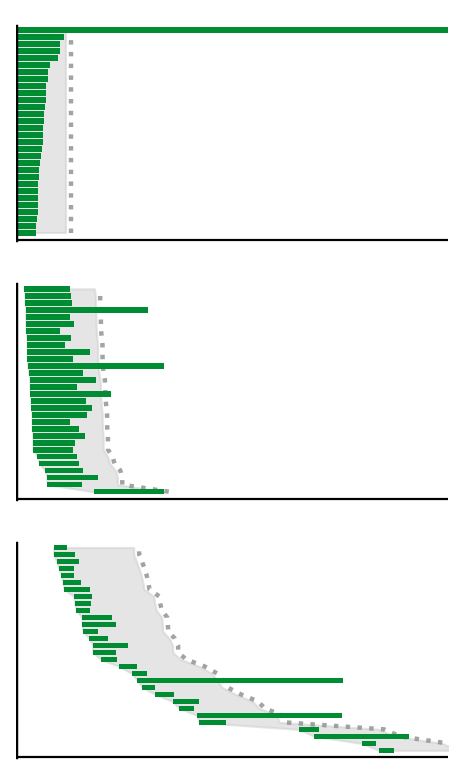

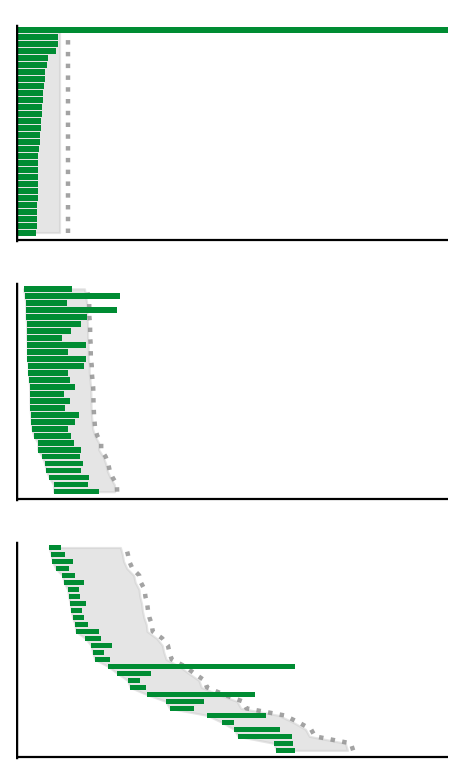

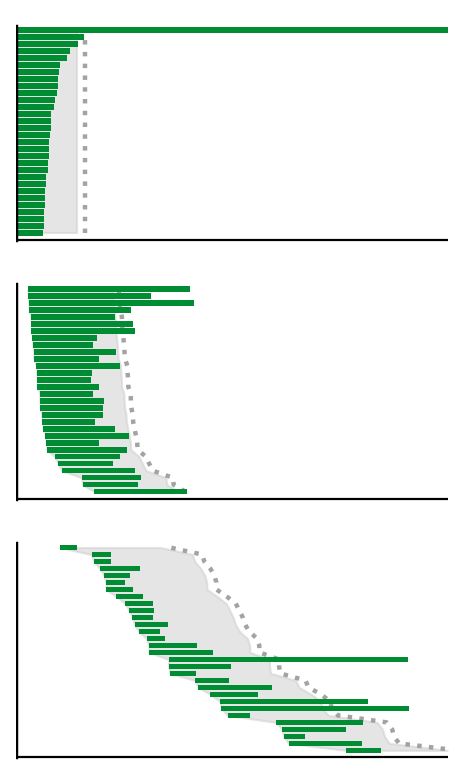

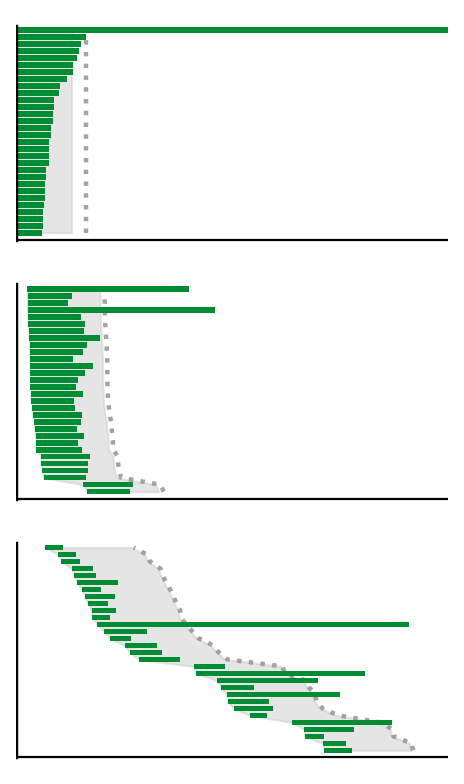

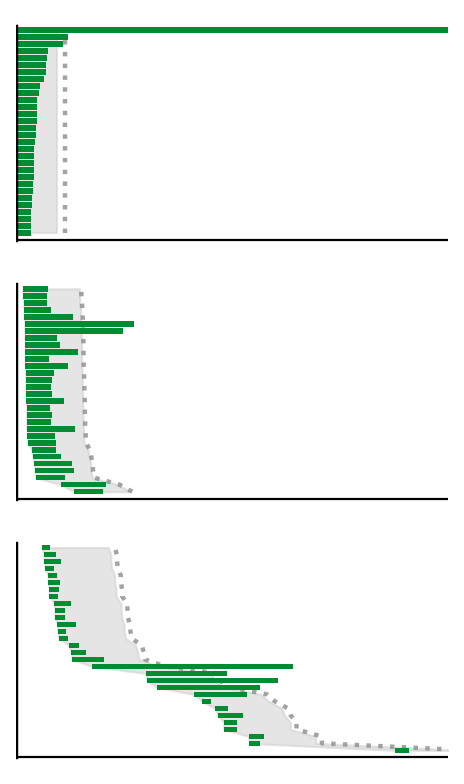

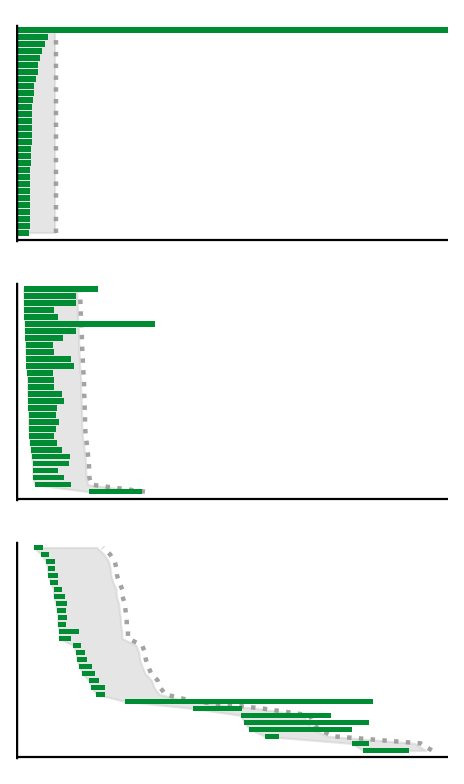

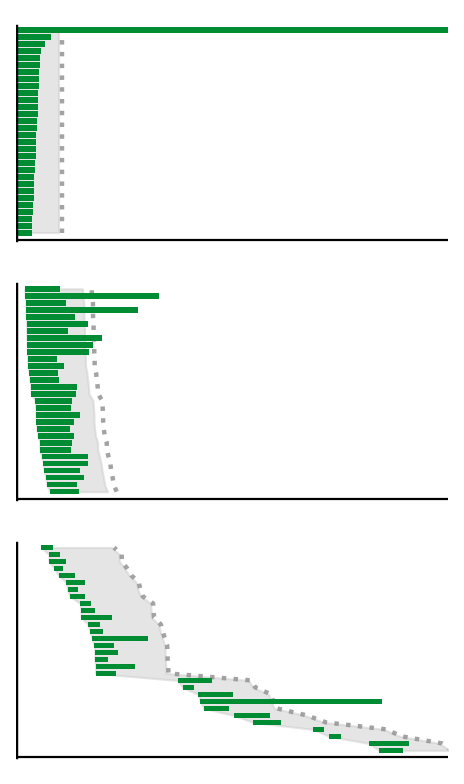

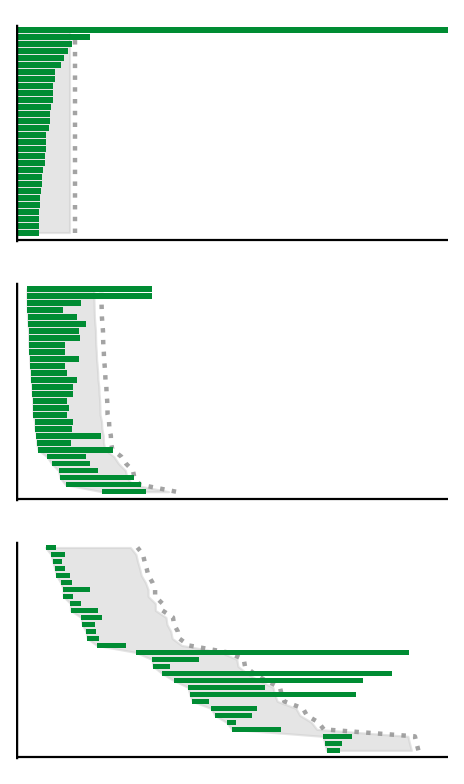

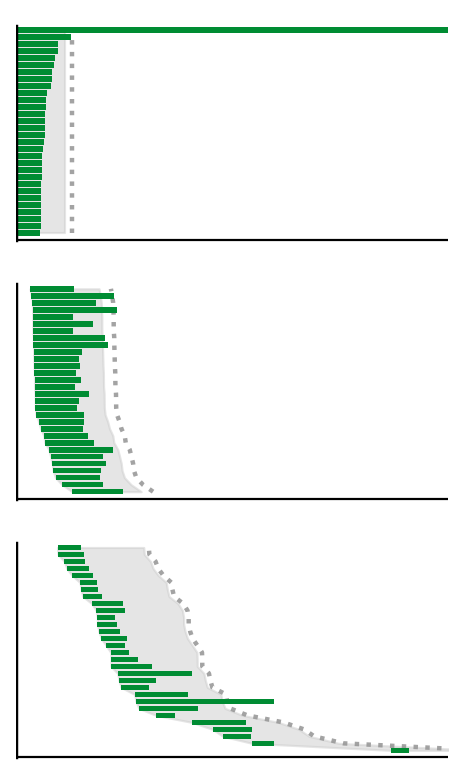

In [9]:
for sess in ('59825ec5641c94b4','c43d9bd004db772b','9190f2fccd52497e',
    '7e888f1d8eaab46b','d5a06b6a7630bb11',
    '1f20835f09e28706','26fd0fbe1e205255',
    '5b92b96313c3fc19','419c1c6b319d0ddf',):
    print(sess)
    try:
        os.mkdir('Figs/functional/' + sess)
    except:
        print('')
    ff = glob.glob('functional/*' + sess + '*_H2.npz')
    f = np.load(ff[0], allow_pickle = True)
    dgms = list(f['dgms'])
    f.close()
    
    shuf_all = {}
    shuffle_name1 = 'functional/' + sess + '_shuffles_concatenated.npz'
    shuffle_name2 = 'functional/' + sess + '_shuffles_concatenated_2.npz'
    shuffle_name3 = 'functional/' + sess + '_shuffles_concatenated3'
    shuf = np.load(shuffle_name1, allow_pickle = True)
    shuf1 = shuf['dgms_shuffles'][()]
    shuf.close()
    for s in shuf1:
        shuf_all[s] = shuf1[s]
        
    shuf = np.load(shuffle_name2, allow_pickle = True)
    shuf2 = shuf['dgms_shuffles'][()]
    shuf.close()
    for s in shuf2:
        shuf_all[s] = shuf2[s]
    np.savez(shuffle_name3, dgms_shuffles = shuf_all)
            
    fig = plot_barcode(dgms, shuffle_name = shuffle_name3)
    fig.savefig('Figs/functional/' + sess + '/barcode.png', transparent = True)
    fig.savefig('Figs/functional/' + sess + '/barcode.pdf', transparent = True)
#    plt.show()

In [29]:
display(Session[((Session['metasession_name']=='9eedcb2fc1c0dc44') |
                (Session['metasession_name']=='5e192857bec0c163') |
                (Session['metasession_name']=='05304a7b5f0d845a'))][['metasession_name',
                                                                    'session_order',
                                                                    'session_name',
                                                                    'animal_name',
                                                                    'timestamp',
                                                                    'timeseries_name',
                                                                    'experiment_type',
                                                                    'username']])

,metasession_name,session_order,session_name,animal_name,timestamp,timeseries_name,experiment_type,username
6,05304a7b5f0d845a,0,5b92b96313c3fc19,88592,2019-11-30 11:45:32,88592-openfield,2Pminiscope_A,horsto
7,05304a7b5f0d845a,1,419c1c6b319d0ddf,88592,2019-11-30 12:12:11,88592-wheel,2Pminiscope_A,horsto
97,5e192857bec0c163,0,1f20835f09e28706,88592,2019-12-12 17:11:19,88592-openfield,2Pminiscope_A,horsto
98,5e192857bec0c163,1,26fd0fbe1e205255,88592,2019-12-12 17:33:55,88592-wheel,2Pminiscope_A,horsto
180,9eedcb2fc1c0dc44,0,7e888f1d8eaab46b,88592,2019-12-09 13:30:20,88592-openfield,2Pminiscope_A,horsto
181,9eedcb2fc1c0dc44,1,d5a06b6a7630bb11,88592,2019-12-09 13:52:33,88592-wheel,2Pminiscope_A,horsto


<Figure size 432x288 with 0 Axes>

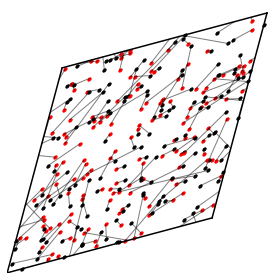

<Figure size 432x288 with 0 Axes>

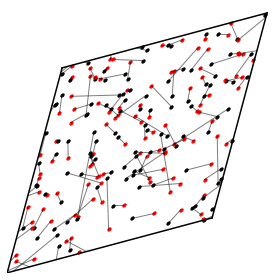

<Figure size 432x288 with 0 Axes>

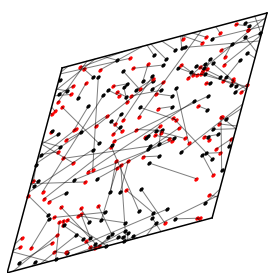

In [35]:
for i in range(3):
    f = np.load('W'+ str(i+1) + '_phases.npz', allow_pickle = True)
    mcs = f['mcs'][()]
    f.close()
    sess_name0, sess_name1 = list(mcs.keys())
    plt.figure()
    plot_phase_distribution(mcs[sess_name0], mcs[sess_name1], )
    plt.tight_layout()
    plt.savefig(sess_name0 +  '_' + sess_name1 + '_phases.png', transparent = True, pad_inches = 0.1)
    plt.savefig(sess_name0 +  '_' + sess_name1 + '_phases.pdf', transparent = True, pad_inches = 0.1)



weijan\97045_20210305_glm.npz [-0.4, 0.65]
weijan\97045_20210307_glm.npz [-0.4, 0.65]
weijan\97045_20210308_glm.npz [-0.4, 0.65]
weijan\97045_20210317_glm.npz [-0.4, 0.65]
weijan\97046_20210308_glm.npz [-0.4, 0.65]
weijan\97046_20210312_glm.npz [-0.4, 0.65]


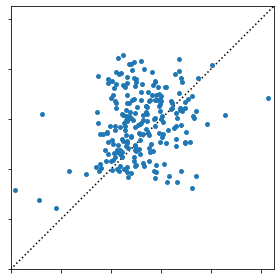

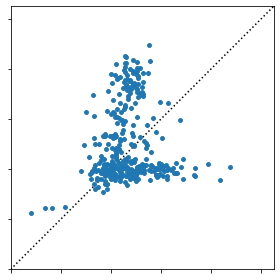

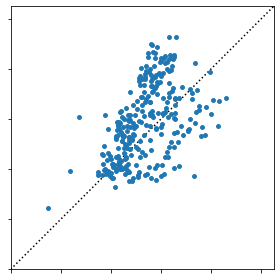

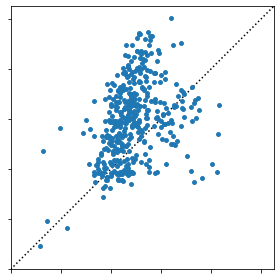

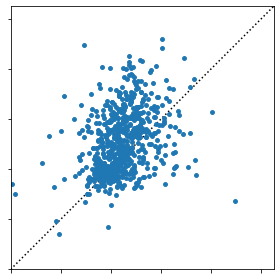

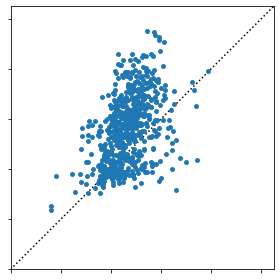

In [4]:
minaxis = np.inf
maxaxis = -np.inf

colors_mods = {}
colors_mods[0] = [[0.7,0.3,0.3]]
colors_mods[1] = [[0.3,0.7,0.3]]
colors_mods[2] = [[0.3,0.3,0.7]]

colors_mods[3] = [[0.7,0.7,0]]
colors_mods[4] = [[0.7,0.,0.7]]
colors_mods[5] = [[0.,0.7,0.7]]

colors_mods[6] = [[0.3,0.3,0]]
colors_mods[7] = [[0.3,0.,0.3]]
colors_mods[8] = [[0.,0.3,0.3]]

colors_mods[9] = [[0.3,0.7,0.7]]
colors_mods[10] = [[0.7,0.3,0.7]]
colors_mods[11] = [[0.7,0.7,0.3]]
it = 0
glm_space_all = {}
glm_tor_all = {}
ff = glob.glob('weijan/*glm*')
for filename in ff:
    minaxis = np.inf
    maxaxis = -np.inf

    fig, ax = plt.subplots(1,1)
    it += 1

    f = np.load(filename, allow_pickle = True)
    tor3 = f['tor3'][()]
    space3 = f['space3'][()]
    f.close()                
    glm_space_all[filename] = space3[:,0,0]
    glm_tor_all[filename] = tor3[:,0,0]    
    nans = ~(np.isnan(space3[:,0,0]) | np.isnan(tor3[:,0,0]))
    
#    ax.scatter(space3[:,0,0], tor3[:,0,0], c = colors_mods[it], s = 15)
    ax.scatter(space3[:,0,0], tor3[:,0,0], s = 15)
#    minaxis = min(minaxis, min(np.min(space3[nans,0,0]), np.min(tor3[nans,0,0])))
#    maxaxis = max(maxaxis, max(np.max(space3[nans,0,0]), np.max(tor3[nans,0,0])))
    minaxis = -0.4
    maxaxis = 0.65
        
    #minaxis = -0.2
    #maxaxis = 0.35
    daxis = (maxaxis-minaxis)*0.0
    print(filename, [minaxis-daxis, maxaxis+daxis])
    ax.plot([minaxis-daxis, maxaxis+daxis],[minaxis-daxis, maxaxis+daxis],ls = ':', c = 'k', zorder = -1)

    ax.set_xlim([minaxis-daxis, maxaxis+daxis])
    ax.set_ylim([minaxis-daxis, maxaxis+daxis])
    ax.set_aspect(1/ax.get_data_ratio())


    xs = [-0.4, -0.2, 0.0, 0.2, 0.4,0.6]
    ax.set_xticks(xs)
    ax.set_yticks(xs)
    ax.set_xticklabels(np.zeros(len(xs),dtype=str))
    ax.set_yticklabels(np.zeros(len(xs),dtype=str))
    fig.tight_layout()
#    plt.show()
    plt.savefig(filename[:filename.find('glm')-1].replace('weijan', 'Figs/weijian') + '/GLM_all.png', transparent = True)
    plt.savefig(filename[:filename.find('glm')-1].replace('weijan', 'Figs/weijian') + '/GLM_all.pdf', transparent = True)

59825ec5641c94b4
7e888f1d8eaab46b
1f20835f09e28706
5b92b96313c3fc19


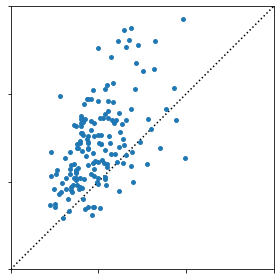

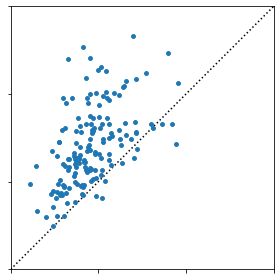

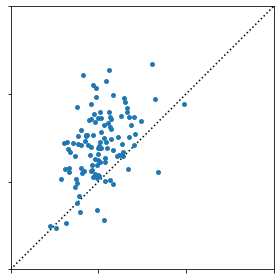

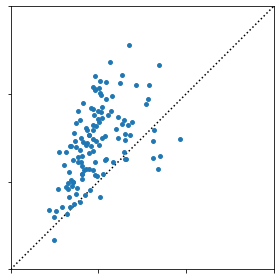

In [149]:
minaxis = np.inf
maxaxis = -np.inf

colors_mods = {}
colors_mods[0] = [[0.7,0.3,0.3]]
colors_mods[1] = [[0.3,0.7,0.3]]
colors_mods[2] = [[0.3,0.3,0.7]]

colors_mods[3] = [[0.7,0.7,0]]
colors_mods[4] = [[0.7,0.,0.7]]
colors_mods[5] = [[0.,0.7,0.7]]

colors_mods[6] = [[0.3,0.3,0]]
colors_mods[7] = [[0.3,0.,0.3]]
colors_mods[8] = [[0.,0.3,0.3]]

colors_mods[9] = [[0.3,0.7,0.7]]
colors_mods[10] = [[0.7,0.3,0.7]]
colors_mods[11] = [[0.7,0.7,0.3]]
it = 0
for sess in ('59825ec5641c94b4',#'c43d9bd004db772b','9190f2fccd52497e',
    '7e888f1d8eaab46b',#'d5a06b6a7630bb11',
    '1f20835f09e28706',#'26fd0fbe1e205255',
    '5b92b96313c3fc19',#'419c1c6b319d0ddf',
            ):
    print(sess)
    f = np.load('Horst/' + sess + '_glm.npz', allow_pickle = True)
    tor3 = f['tor3'][:,0,0]
    space3 = f['space3'][:,0,0]
    f.close()
    snot = ~((np.isnan(tor3)) | (tor3>0.99) | (tor3<-0.3) |
           (np.isnan(space3)) | (space3>0.99) | (space3<-0.3))
    
    fig, ax = plt.subplots(1,1)
    it += 1
    glm_space_all['88592' + sess] = space3[snot]
    glm_tor_all['88592' + sess] = tor3[snot]
    ax.scatter(space3, tor3, s = 15)
#    minaxis = min(minaxis, min(np.min(space3[snot]), np.min(tor3[snot])))
#    maxaxis = max(maxaxis, max(np.max(space3[snot]), np.max(tor3[snot])))        
#    daxis = (maxaxis-minaxis)*0.05
    minaxis = -0.1
    maxaxis = 0.5
    daxis = 0
    ax.plot([minaxis-daxis, maxaxis+daxis],[minaxis-daxis, maxaxis+daxis],ls = ':', c = 'k', zorder = -1)

    ax.set_xlim([minaxis-daxis, maxaxis+daxis])
    ax.set_ylim([minaxis-daxis, maxaxis+daxis])
    ax.set_aspect(1/ax.get_data_ratio())
    xs = np.linspace(minaxis, maxaxis, 4)
#    xs = [-0.3, -0.15, 0.0, 0.15, 0.3]
    ax.set_xticks(xs)
    ax.set_yticks(xs)
    ax.set_xticklabels(np.zeros(len(xs),dtype=str))
    ax.set_yticklabels(np.zeros(len(xs),dtype=str))
    fig.tight_layout()
#    plt.savefig('Figs/functional/' + sess + '/GLM_all.png', transparent = True)
#    plt.savefig('Figs/functional/' + sess + '/GLM_all.pdf', transparent = True)


In [134]:

numbins_all = [8, 10, 12, 15,]
LAMs = [0,1,np.sqrt(10),10,]
maxs = -np.inf
for i1, num_bins in enumerate(numbins_all):
    for i2, LAM in enumerate(LAMs):            
        print(num_bins, LAM, np.median(space3[:, i1,i2]))
        maxs = max(maxs, np.median(space3[:, i1,i2]))

8 0 -0.7145054904046708
8 1 0.0705893567812107
8 3.1622776601683795 0.03976946682263649
8 10 0.014430529016517146
10 0 -0.9290880067660845
10 1 0.07069370332026664
10 3.1622776601683795 0.03577061721958941
10 10 0.014883655850235877
12 0 -1.1226250598750398
12 1 0.07448673979466558
12 3.1622776601683795 0.036117024951706767
12 10 0.007263811543665677
15 0 -1.5938689395635197
15 1 0.06645988697700878
15 3.1622776601683795 0.02908166715817967
15 10 0.011777540165035738


59825ec5641c94b4
0 0
c43d9bd004db772b
0 0
9190f2fccd52497e
0 0
7e888f1d8eaab46b
0 0
1f20835f09e28706
0 0
5b92b96313c3fc19
0 0


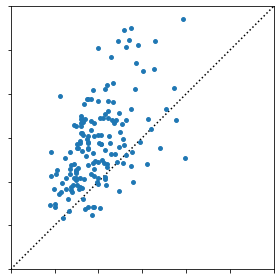

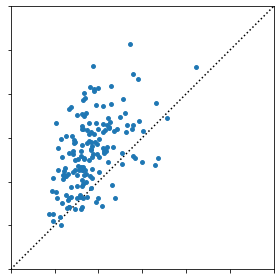

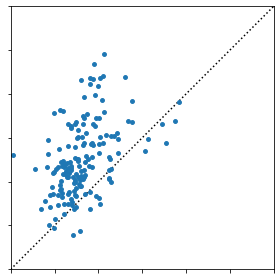

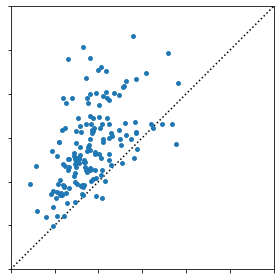

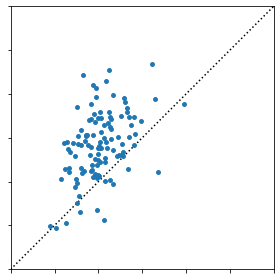

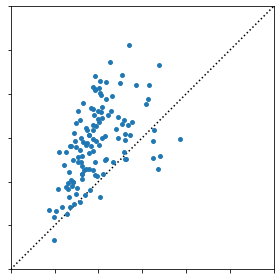

In [156]:
minaxis = np.inf
maxaxis = -np.inf

colors_mods = {}
colors_mods[0] = [[0.7,0.3,0.3]]
colors_mods[1] = [[0.3,0.7,0.3]]
colors_mods[2] = [[0.3,0.3,0.7]]

colors_mods[3] = [[0.7,0.7,0]]
colors_mods[4] = [[0.7,0.,0.7]]
colors_mods[5] = [[0.,0.7,0.7]]

colors_mods[6] = [[0.3,0.3,0]]
colors_mods[7] = [[0.3,0.,0.3]]
colors_mods[8] = [[0.,0.3,0.3]]

colors_mods[9] = [[0.3,0.7,0.7]]
colors_mods[10] = [[0.7,0.3,0.7]]
colors_mods[11] = [[0.7,0.7,0.3]]
it = 0
for sess in ('59825ec5641c94b4','c43d9bd004db772b','9190f2fccd52497e',
    '7e888f1d8eaab46b',#'d5a06b6a7630bb11',
    '1f20835f09e28706',#'26fd0fbe1e205255',
    '5b92b96313c3fc19',#'419c1c6b319d0ddf',
            ):
    print(sess)
    f = np.load('Horst/' + sess + '_glm.npz', allow_pickle = True)
    tor3 = f['tor3'][:,0,0]
    space3 = f['space3'][:,0,0]
    f.close()
    snot = ~((np.isnan(tor3)) | (tor3>0.99) | (tor3<-0.3) |
           (np.isnan(space3)) | (space3>0.99) | (space3<-0.3))
    
    fig, ax = plt.subplots(1,1)
    it += 1
    glm_space_all['88592' + sess] = space3[snot]
    glm_tor_all['88592' + sess] = tor3[snot]
    ax.scatter(space3, tor3, s = 15)
#    minaxis = min(minaxis, min(np.min(space3[snot]), np.min(tor3[snot])))
#    maxaxis = max(maxaxis, max(np.max(space3[snot]), np.max(tor3[snot])))        
#    daxis = (maxaxis-minaxis)*0.05
    minaxis = -0.1
    maxaxis = 0.5
    daxis = 0
    ax.plot([minaxis-daxis, maxaxis+daxis],[minaxis-daxis, maxaxis+daxis],ls = ':', c = 'k', zorder = -1)

    ax.set_xlim([minaxis-daxis, maxaxis+daxis])
    ax.set_ylim([minaxis-daxis, maxaxis+daxis])
    ax.set_aspect(1/ax.get_data_ratio())

    xs = [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    ax.set_xticks(xs)
    ax.set_yticks(xs)
    ax.set_xticklabels(np.zeros(len(xs),dtype=str))
    ax.set_yticklabels(np.zeros(len(xs),dtype=str))
    fig.tight_layout()
    plt.savefig('Figs/functional/' + sess + '/GLM_all.png', transparent = True)
    plt.savefig('Figs/functional/' + sess + '/GLM_all.pdf', transparent = True)
    print(np.sum(~snot), np.sum((space3[snot]>maxaxis) | 
                                (space3[snot]<minaxis) | 
                                (tor3[snot]>maxaxis) | 
                                (tor3[snot]<minaxis)), )


In [6]:
from scipy.stats import wilcoxon
spacescores = glm_space_all.copy()
LOOtorscores = glm_tor_all.copy()

GLM_Toroidal = []
GLM_Spatial = []
maxEV = -np.inf
minEV = np.inf
for fi in spacescores:
    spacescores_curr, torscores_curr = spacescores[fi].copy(), LOOtorscores[fi].copy()
    spacescores_curr[np.isnan(spacescores_curr)] = 0
    torscores_curr[np.isnan(torscores_curr)] = 0
    
    maxEV =  max(maxEV, max(np.max(torscores_curr), np.max(spacescores_curr)))
    minEV =  min(minEV, min(np.min(torscores_curr), np.min(spacescores_curr)))
    ax.scatter(spacescores_curr, torscores_curr, s = 10)#, c = colors_envs[fi])
    p  = wilcoxon(torscores_curr-spacescores_curr, alternative='greater')
    print(fi)
    print(' n: ' + str(len(torscores_curr)) )
    print(' p: ' + str(p) )
    print('')
    GLM_Toroidal.extend([np.median(torscores_curr)])
    GLM_Toroidal.extend([np.std(torscores_curr)/np.sqrt(len(torscores_curr))])
    GLM_Spatial.extend([np.median(spacescores_curr)])
    GLM_Spatial.extend([np.std(spacescores_curr)/np.sqrt(len(spacescores_curr))])


weijan\97045_20210305_glm.npz
 n: 228
 p: WilcoxonResult(statistic=18933.0, pvalue=1.8495473561963708e-09)

weijan\97045_20210307_glm.npz
 n: 350
 p: WilcoxonResult(statistic=35658.0, pvalue=0.003316114042835927)

weijan\97045_20210308_glm.npz
 n: 293
 p: WilcoxonResult(statistic=29558.0, pvalue=3.5707608378145084e-09)

weijan\97045_20210317_glm.npz
 n: 428
 p: WilcoxonResult(statistic=75283.0, pvalue=2.246050803590316e-35)

weijan\97046_20210308_glm.npz
 n: 635
 p: WilcoxonResult(statistic=153619.0, pvalue=8.743112034241636e-33)

weijan\97046_20210312_glm.npz
 n: 637
 p: WilcoxonResult(statistic=167001.0, pvalue=6.996847657015097e-52)

8859259825ec5641c94b4
 n: 128
 p: WilcoxonResult(statistic=7999.0, pvalue=1.6953911985644324e-20)

885927e888f1d8eaab46b
 n: 132
 p: WilcoxonResult(statistic=8228.0, pvalue=1.3980501424206305e-18)

885921f20835f09e28706
 n: 68
 p: WilcoxonResult(statistic=2191.0, pvalue=2.4803958395717466e-10)

885925b92b96313c3fc19
 n: 75
 p: WilcoxonResult(statistic=2

In [9]:
colors_mods = {}
colors_mods['97045'] = [[0.7,0.3,0.3]]
colors_mods['97046'] = [[0.3,0.7,0.3]]
colors_mods['88592'] = [[0.3,0.3,0.7]]

colors_mods[3] = [[0.7,0.7,0]]
colors_mods[4] = [[0.7,0.,0.7]]
colors_mods[5] = [[0.,0.7,0.7]]

colors_mods[6] = [[0.3,0.3,0]]
colors_mods[7] = [[0.3,0.,0.3]]
colors_mods[8] = [[0.,0.3,0.3]]

colors_mods[9] = [[0.3,0.7,0.7]]
colors_mods[10] = [[0.7,0.3,0.7]]
colors_mods[11] = [[0.7,0.7,0.3]]
animals = []
sess 
for f in spacescores:
    if f.find('97045')>-1:
        animals.append('97045')
    elif f.find('97046')>-1:
        animals.append('97046')
    elif f.find('88592')>-1:
        animals.append('88592')
def plot_stats(stats_tor, stats_space, names):
    num_mods = len(stats_tor)
    num_mods = int(num_mods/2)
    fig = plt.figure(figsize=(2,6))
    ax = fig.add_subplot(111)
    xs = [0.01, 0.09]
    if len(stats_space):
        if len(stats_space):
            for i in range(num_mods):
                i*=2

                ax.scatter(xs, [stats_tor[i],stats_space[i]], s = 150, marker='.',  alpha  = 0.5, 
                           zorder=-1, c = colors_mods[names[int(i/2)]])
                ax.plot(xs, [stats_tor[i],stats_space[i]], c = colors_mods[names[int(i/2)]][0], lw = 1, alpha = 0.5, zorder = -2)

            for i in range(num_mods):
                i*=2
                ax.errorbar(xs, [stats_tor[i],stats_space[i]], lw = 1, yerr=[stats_tor[i+1],stats_space[i+1]], 
                    fmt='none', alpha = 1, zorder=-2,  c = colors_mods[names[int(i/2)]][0])

    ax.set_xlim([0,0.1])
    ax.set_ylim([-0.05,0.25])
    
    ax.set_xticks(xs)
    ys = [-0.05,  0.0, 0.05, 0.1, 0.15,0.2]
    ax.set_xticklabels(np.zeros(len(xs),dtype=str))
    ax.xaxis.set_tick_params(width=1, length =7)
    ax.set_yticks(ys)
    ax.set_yticklabels(np.zeros(len(ys),dtype=str))
    ax.yaxis.set_tick_params(width=1, length =7)

    
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/(abs(y1-y0))*3.5)
    
    plt.gca().axes.spines['top'].set_visible(False)
    plt.gca().axes.spines['right'].set_visible(False)
    

plot_stats(GLM_Toroidal, GLM_Spatial, animals)
plt.savefig('Figs/GLM_mean_comparison.png', transparent = True)
plt.savefig('Figs/GLM_mean_comparison.pdf', transparent = True)
